# Определение перспективного тарифа для телеком компании

## Описание проекта

Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:

*Тариф «Смарт»*
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

*Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

## Описание данных
*Таблица users (информация о пользователях):*
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

*Таблица calls (информация о звонках):*

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного 

### План анализа:
 1. [Открытие данных, изучение общей информации](#1)
 2. [Подготовка данных](#2) 
 3. [Анализ данных](#3)
 4. [Проверка гипотез](#4)
 5. [Общий вывод](#5)

<a id="1"></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
calls_df = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
internet_df = pd.read_csv('/datasets/internet.csv', index_col='Unnamed: 0', parse_dates=['session_date'])
messages_df = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
users_df = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])

Изучим общую информацию по каждой таблице:

#### Звонки

In [3]:
calls_df.info()
calls_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls_df.duplicated().sum()

0

Text(0, 0.5, 'user_id')

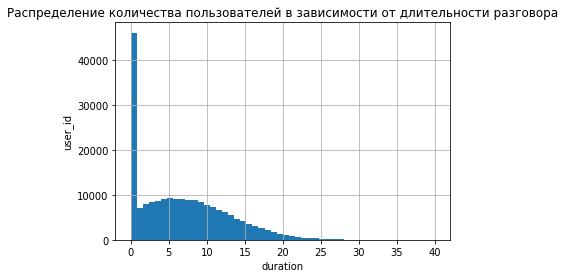

In [5]:
#построим гистограмму распределения количества пользователей в зависимости от длительности разговора
calls_df['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

In [6]:
print('Количетсво звонком у которых - длительность звонка менее 1 минуты: {}'.format(len(calls_df[calls_df.duration < 1])))
print('Количетсво звонком у которых - длительность звонка = 0 минуты: {}'.format(len(calls_df[calls_df.duration == 0])))

Количетсво звонком у которых - длительность звонка менее 1 минуты: 47927
Количетсво звонком у которых - длительность звонка = 0 минуты: 39613


### Вывод:

calls_df -это дата со звонками всех пользователей. Состоит из 4 столбцов и 202607 строк. Пропущенных значений нет.

- Необходимо поменять типы данных столбцов:
  duration - на int.  
- Очень много звонков с длительностью 0 секунд. Это могут быть пропущенные звонки, как подсказано в описании проекта. 25% всей выборки имеют длительность в районе 1 секунды.

#### Итрернет

In [7]:
internet_df.info()
internet_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [8]:
internet_df.duplicated().sum()

0

Text(0, 0.5, 'user_id')

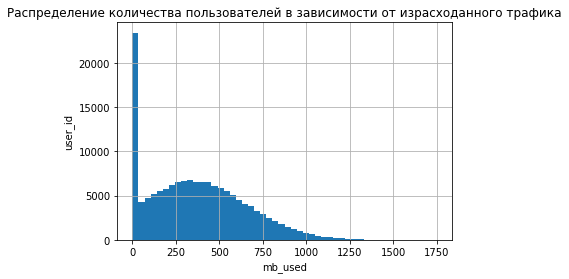

In [9]:
#построим гистограмму распределения количества пользователей в зависимости от израсходанного трафика
internet_df['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от израсходанного трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')

In [10]:
print('Количество сессий объёма потраченного за сессию интернет-трафика равным 0 Мб: {}'.format(len(internet_df.query('mb_used == 0 '))))

Количество сессий объёма потраченного за сессию интернет-трафика равным 0 Мб: 19598


### Вывод

internet_df -это дата по трафику интернета для всех пользователей. Состоит из 4 столбцов и 149396 строк. Пропущенных значений нет.
- Необходимо поменять типы данных:
  mb_used - на int.  
- Очень много объёма потраченного за сессию интернет-трафика = 0 Мб.

#### Сообщения

In [11]:
messages_df.info()
messages_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
messages_df.duplicated().sum()

0

### Вывод

messages_df -это дата с использованными сообщениями всех пользователей. Состоит из 3 столбцов и 123036 строк. Пропущенных значений нет.


#### Тарифы

In [13]:
tariffs_df.info()
tariffs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Data_tariffs-это дата с информацией о тарифах. Состоит из 8 столбцов и 2 строк. Пропущенных значений нет.


#### Пользователи

In [14]:
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [15]:
users_df.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [16]:
users_df.duplicated().sum()

0

In [17]:
#Посмотрим кол-во уникальных значений по тарифу
print(users_df['tariff'].value_counts(), '\n', (users_df['tariff'].value_counts()/500)*100)

smart    351
ultra    149
Name: tariff, dtype: int64 
 smart    70.2
ultra    29.8
Name: tariff, dtype: float64


### Вывод

users_df -это дата с информацией о пользователях. Состоит из 8 столбцов и 500 строк. 

- Пропущенные значения есть. У столбца churn_date есть 462 пропуска.Это столбец с датой прекращения пользования тарифом (исходя из информации описания данных, если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

<a id="2"></a>
## Шаг 2. Подготовьте данные

#### Звонки
Округлить значения минут разговора, в большую стороную:

In [18]:
calls_df['duration'] = calls_df['duration'].apply(np.ceil)
calls_df.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Text(0, 0.5, 'user_id')

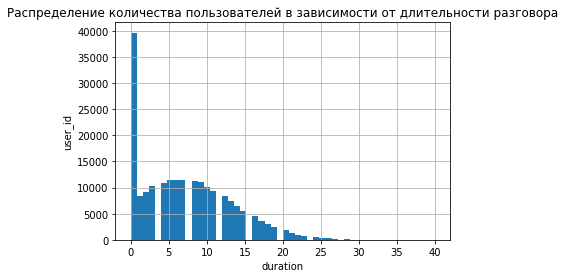

In [19]:
#Построем гистограмму, посмотрим на распределение:
calls_df['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

На графике явный выброс. Т.к. нулевая длительность звонка не расходует лимит минут и эти данные не используются в формировании конечной выручки, удаляем эти строки.

In [20]:
calls_df['duration'] = calls_df['duration'].replace(0, np.NaN)
calls_df = calls_df.dropna()

In [21]:
print('Количетсво звонком у которых - длительность звонка = 0 минуты: {}'.format(len(calls_df[calls_df.duration == 0])))

Количетсво звонком у которых - длительность звонка = 0 минуты: 0


Text(0, 0.5, 'user_id')

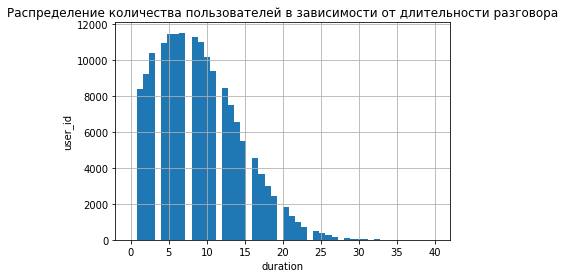

In [22]:
calls_df['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

Распределение нормальное.

#### Интернет трафик
Округлить значения интернет-трафика, в большую стороную:

In [23]:
internet_df['mb_used'] = internet_df['mb_used'].apply(np.ceil)
internet_df['mb_used'].head()

0     113.0
1    1053.0
2    1198.0
3     551.0
4     303.0
Name: mb_used, dtype: float64

Text(0, 0.5, 'user_id')

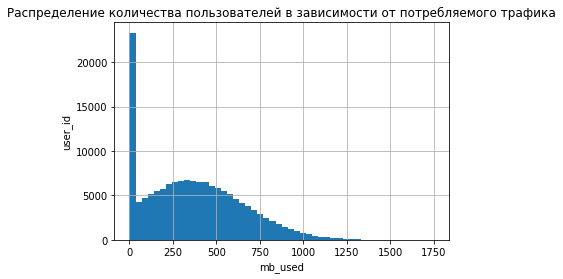

In [24]:
internet_df['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от потребляемого трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')

На графике присутствует выбром с нулевыми значениями. Возможно при подклучении к интернету пользователи просто им не пользовались, поэтому потребления трафика нет. Удаляем данные с 0 трафиком.

In [25]:
internet_df['mb_used'] = internet_df['mb_used'].replace(0, np.NaN)
internet_df = internet_df.dropna()

In [26]:
print('Количество сессий объёма потраченного за сессию интернет-трафика равным 0 Мб: {}'.format(len(internet_df.query('mb_used == 0 '))))

Количество сессий объёма потраченного за сессию интернет-трафика равным 0 Мб: 0


Text(0, 0.5, 'user_id')

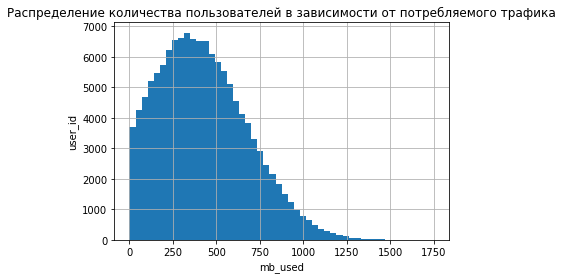

In [27]:
internet_df['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от потребляемого трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')

Распределение нормальное.

### Подготовка пользовательских данных
Найдем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам_год;
- количество отправленных сообщений по месяцам_год;
- объем израсходованного интернет-трафика по месяцам_год.

Добавим в каждую из 3 базовых таблиц с данными колонку с месяцем_год. Создадим функцию для автоматизации добавления столбца 'month_year' в нужных файлах
 

In [28]:
def plus_month_year(data,columns):
    for row in columns:
        data['month_year'] = data[row].dt.to_period('M')

In [29]:
plus_month_year(calls_df, ['call_date'])
plus_month_year(internet_df, ['session_date'])
plus_month_year(messages_df, ['message_date'])

Создадим функцию для автоматизации выводов сводной таблицы по звонкам, смс и интернет-трафику:

In [30]:
def data_pivot_table(data, index, values, agg):
    return data.pivot_table(
            index=index,
            values=values,
            aggfunc=agg
        ) 

Сделаем сводную таблицу по месяцам_год и звонкам для каждого user_id:

In [31]:
calls_group=data_pivot_table(calls_df, ['month_year', 'user_id'], 'duration', ['count', 'sum'])
calls_group.reset_index()

,month_year,user_id,count,sum
,,,duration,duration
0,2018-01,1005,11,95.0
1,2018-01,1032,44,380.0
2,2018-01,1045,1,9.0
3,2018-01,1055,47,551.0
4,2018-01,1071,18,194.0
...,...,...,...,...
3163,2018-12,1494,54,418.0
3164,2018-12,1495,120,1031.0
3165,2018-12,1496,65,518.0


Сделаем сводную таблицу по месяцам_год и количеству смс для каждого user_id:

In [32]:
messages_group=data_pivot_table(messages_df, ['month_year', 'user_id'], 'id', 'count')
messages_group.reset_index()

,month_year,user_id,id
0,2018-01,1005,7
1,2018-01,1032,38
2,2018-01,1045,5
3,2018-01,1055,30
4,2018-01,1071,16
...,...,...,...
2712,2018-12,1493,78
2713,2018-12,1495,84
2714,2018-12,1496,51
2715,2018-12,1497,17


Сделаем сводную таблицу по месяцам_год и использованному интернет_трафику для каждого user_id:

In [33]:
internet_group=data_pivot_table(internet_df, ['month_year', 'user_id'], 'mb_used', 'sum')
internet_group.reset_index()

,month_year,user_id,mb_used
0,2018-01,1005,2730.0
1,2018-01,1032,24147.0
2,2018-01,1045,2348.0
3,2018-01,1055,17111.0
4,2018-01,1071,15622.0
...,...,...,...
3196,2018-12,1494,17645.0
3197,2018-12,1495,23450.0
3198,2018-12,1496,20757.0
3199,2018-12,1497,19940.0


### Данные готовы, расчитаем помесячную выручку с каждого пользователя

In [34]:
#Сведем все необходимые параметры в общую таблицу:
group_all=pd.DataFrame()

In [35]:
import warnings
warnings.filterwarnings("ignore")

group_all = (
    calls_group.merge(messages_group, on=['user_id','month_year'], how='outer').
    merge(internet_group, on=['user_id','month_year'], how='outer').
    sort_values(by = ['user_id','month_year'])
)
group_all = group_all.reset_index()
group_all

,user_id,month_year,"(count, duration)","(sum, duration)",id,mb_used
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0
...,...,...,...,...,...,...
3209,1498,2018-10,30.0,247.0,42.0,20604.0
3210,1499,2018-09,8.0,70.0,11.0,1848.0
3211,1499,2018-10,44.0,449.0,48.0,17809.0
3212,1499,2018-11,62.0,612.0,59.0,17984.0


In [36]:
#посмотрим общую информацию по сводной таблице:
group_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id              3214 non-null int64
month_year           3214 non-null period[M]
(count, duration)    3168 non-null float64
(sum, duration)      3168 non-null float64
id                   2717 non-null float64
mb_used              3201 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 150.8 KB


In [37]:
group_all = group_all.drop_duplicates()

- После формирования датафрейма по месяцам появились пропуски. Некоторые пользователи в некоторые месяцы пользовались не всеми услугами. Заполним пропуски нулями. 
- Также необходимо изменить тип данных *float* на *int*. 
- Для более читабельной таблицы переименнуем столбцы.

In [38]:
#Переименуем столбцы
group_all.set_axis(['user_id', 'month_year','count_calls', 'minutes', 'messages', 'mb'], axis = 'columns', inplace = True) 
group_all.head()

,user_id,month_year,count_calls,minutes,messages,mb
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0


In [39]:
#заполняем пропуски (NaN) в data_services нулями (0)
group_all = group_all.fillna(0)
    
group_all.info()
group_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month_year     3214 non-null period[M]
count_calls    3214 non-null float64
minutes        3214 non-null float64
messages       3214 non-null float64
mb             3214 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 175.8 KB


,user_id,month_year,count_calls,minutes,messages,mb
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0


In [40]:
#Переведем интернет трафик в Гб и округлим значения вверх, 
#так как перерасход по интернету клиент оплачивает полными пакетами трафика, т.е. покупает 1 Гб, 2 Гб и т.д.
group_all['mb'] = group_all['mb']/1024
group_all['mb'] = group_all['mb'].apply(np.ceil)

In [41]:
group_all[['count_calls','minutes','messages','mb']]=group_all[['count_calls','minutes','messages','mb']].astype('int')
group_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month_year     3214 non-null period[M]
count_calls    3214 non-null int64
minutes        3214 non-null int64
messages       3214 non-null int64
mb             3214 non-null int64
dtypes: int64(5), period[M](1)
memory usage: 175.8 KB


#### Для подсчета выручки добавим данные о пользователях и тарифах:

In [42]:
#Сперва переименуем столбец в файле тарифов, так так такоеже назывние есть в таблице пользователи:
tariffs_df = tariffs_df.rename(columns={'tariff_name': 'tariff'})

In [43]:
# соединяем 3 таблицы
group_all = group_all.merge(users_df, on='user_id', how='left')

In [44]:
group_all.head()

,user_id,month_year,count_calls,minutes,messages,mb,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05,17,159,22,3,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06,28,172,60,23,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07,41,340,75,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08,42,408,81,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09,46,466,57,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [45]:
#удалим ненужные столбцы чтобы не загромождать таблицу
del group_all['first_name']
del group_all['last_name']
del group_all['age']

In [46]:
group_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 10 columns):
user_id        3214 non-null int64
month_year     3214 non-null period[M]
count_calls    3214 non-null int64
minutes        3214 non-null int64
messages       3214 non-null int64
mb             3214 non-null int64
churn_date     187 non-null datetime64[ns]
city           3214 non-null object
reg_date       3214 non-null datetime64[ns]
tariff         3214 non-null object
dtypes: datetime64[ns](2), int64(5), object(2), period[M](1)
memory usage: 276.2+ KB


Теперь для каждого пользователя посчитаем помесячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [47]:
#подтянем к нашей таблице данные по тарифам:
#group_all = group_all.merge(tariffs_df, on='tariff', how='left')

In [48]:
#Функция расчета помесячной выручки с каждого пользователя
def month_calc(row):
    calls = row['minutes']
    messages = row['messages']
    internet = row['mb']
    tariff = row['tariff']
   
    # достанем лимиты по тарифам на звонки, смс и интернет
    minutes_lim = tariffs_df.loc[tariffs_df['tariff'] == tariff, 'minutes_included'].array[0]
    messages_lim = tariffs_df.loc[tariffs_df['tariff'] == tariff, 'messages_included'].array[0]
    internet_lim = tariffs_df.loc[tariffs_df['tariff'] == tariff, 'mb_per_month_included'].array[0]
    #print(internet_lim)
    # переплата по звонкам
    call_overlimit = max(calls - minutes_lim, 0)
    call_overpay = call_overlimit * tariffs_df.loc[tariffs_df['tariff'] == tariff, 'rub_per_minute'].array[0]
   
    messages_overlimit = max(messages - messages_lim, 0)
    messages_overpay = messages_overlimit * tariffs_df.loc[tariffs_df['tariff'] == tariff, 'rub_per_message'].array[0]
 
   
    internet_overlimit = max(internet - (internet_lim/1024), 0)
    internet_overpay = internet_overlimit * tariffs_df.loc[tariffs_df['tariff'] == tariff, 'rub_per_gb'].array[0]
 
   
    return (call_overpay + messages_overpay + internet_overpay + tariffs_df.loc[tariffs_df['tariff'] == tariff, 'rub_monthly_fee'].array[0])
 
group_all['revenue'] = group_all.apply(month_calc, axis=1)

In [49]:
group_all[['user_id', 'month_year', 'revenue', 'tariff']]

,user_id,month_year,revenue,tariff
0,1000,2018-05,1950.0,ultra
1,1000,2018-06,1950.0,ultra
2,1000,2018-07,1950.0,ultra
3,1000,2018-08,1950.0,ultra
4,1000,2018-09,1950.0,ultra
...,...,...,...,...
3209,1498,2018-10,1750.0,smart
3210,1499,2018-09,550.0,smart
3211,1499,2018-10,1150.0,smart
3212,1499,2018-11,1513.0,smart


Построим график распределения количества пользователей в зависимости от выручки:

In [50]:
group_all['revenue'].astype(int)

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3209    1750
3210     550
3211    1150
3212    1513
3213     598
Name: revenue, Length: 3214, dtype: int64

In [51]:
#group_all['revenue'].sum()

Text(0, 0.5, 'Пользователи')

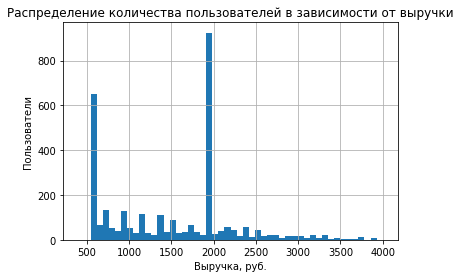

In [52]:
group_all['revenue'].hist(bins=50, range=(400,4000))
plt.title('Распределение количества пользователей в зависимости от выручки')
plt.xlabel('Выручка, руб.')
plt.ylabel('Пользователи')

In [53]:
##посмотрим суммарную выручку по тарифам
group_all.groupby('tariff')['revenue'].sum()

tariff
smart    2885751.0
ultra    2040000.0
Name: revenue, dtype: float64

In [54]:
smart = group_all.query("tariff == 'smart'")
print('Количество пользователей смарт: {}'.format(len(smart.groupby('user_id'))))
ultra = group_all.query("tariff == 'ultra'")
print('Количество пользователей ультра: {}'.format(len(ultra.groupby('user_id'))))

Количество пользователей смарт: 350
Количество пользователей ультра: 148


### Вывод

- На графике видно 2 пика в 550 руб и 1950 руб, это и есть наша абонентская плата по тарифам smart и ultra соответственно. 
- Тариф smart приносит больше выручки чем тариф ultra.
- Количество пользователей смарт: 350.
- Количество пользователей ультра: 148.

<a id="3"></a>
## Шаг 3. Проанализируйте данные

#### Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [55]:
#длительность звонков по тарифам и по месяцам
group_all.pivot_table(index = 'month_year', values = ('minutes', 'messages', 'mb'), columns = 'tariff', )

mb              messages                minutes            
tariff          smart      ultra      smart      ultra       smart       ultra
month_year                                                                    
2018-01      8.735294  13.333333  18.235294  33.777778  203.852941  428.111111
2018-02     11.844828  12.000000  24.086207  21.958333  298.689655  297.125000
2018-03     15.246753  17.702703  31.857143  32.297297  390.051948  489.648649
2018-04     13.642857  17.000000  30.741071  31.563636  367.133929  458.018182
2018-05     15.943262  19.432836  33.773050  37.850746  387.361702  510.328358
2018-06     15.981707  18.964286  33.402439  41.726190  395.640244  479.702381
2018-07     15.910448  20.538462  33.751244  49.846154  408.353234  545.791209
2018-08     16.782979  19.635514  33.638298  48.439252  421.468085  510.775701
2018-09     16.423077  19.252174  33.638462  52.286957  428.611538  539.443478
2018-10     16.911565  20.089431  33.765306  58.430894  426.136054  558.081301
2018-11     17.028481  19.828358  34.075949  55.791045  435.265823  541.380597
2018-12     18.234421  21.784173  35.994065  60.611511  478.560831  592.805755

Найдем среднее, дисперсию и стандартное отклонение:

In [56]:
group_all.pivot_table(index = 'tariff', values = ['minutes', 'messages', 'mb'], aggfunc = ['mean', 'var','std'])

mean                               var               \
               mb   messages     minutes         mb     messages   
tariff                                                             
smart   16.359354  33.384029  417.934948  33.160304   796.812958   
ultra   19.525888  49.363452  526.623350  97.334949  2285.266143   

                            std                         
              minutes        mb   messages     minutes  
tariff                                                  
smart    36219.315784  5.758498  28.227876  190.313730  
ultra   100873.633397  9.865848  47.804457  317.606098

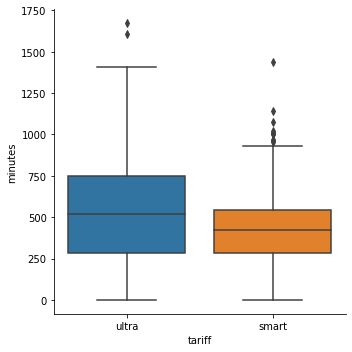

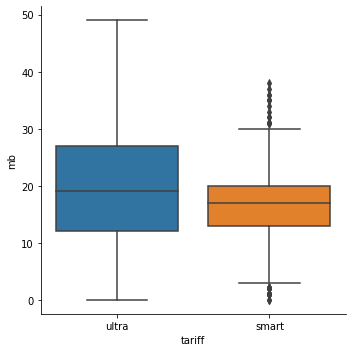

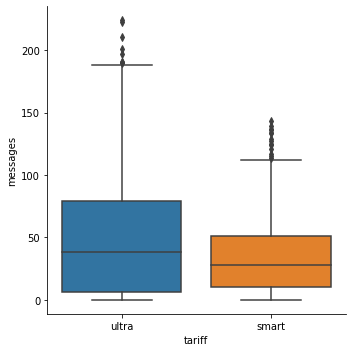

In [57]:
for column in ['minutes', 'mb', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=group_all, orient='v')

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт». Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

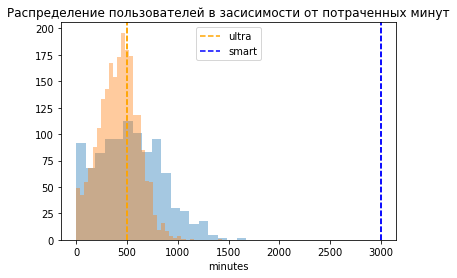

In [58]:
#строим график распределения длительности звонков по двум тарифам:
for tariff in ['ultra', 'smart']:
    sns.distplot(group_all.query('tariff == @tariff')['minutes'], kde=False, label=tariff)
    plt.title('Распределение пользователей в засисимости от потраченных минут')
    plt.axvline(500, color = 'orange', linestyle = '--')
    plt.axvline(3000, color = 'blue', linestyle = '--' )
_=plt.legend(['ultra', 'smart'])

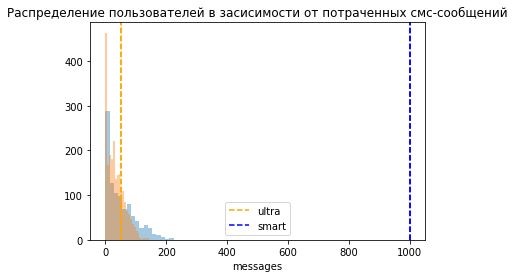

In [59]:
#строим график распределения смс-сообщений по двум тарифам:
for tariff in ['ultra', 'smart']:
    sns.distplot(group_all.query('tariff == @tariff')['messages'], kde=False, label=tariff)
    plt.title('Распределение пользователей в засисимости от потраченных смс-сообщений')
    plt.axvline(50, color = 'orange', linestyle = '--')
    plt.axvline(1000, color = 'blue', linestyle = '--' )
_ = plt.legend(['ultra', 'smart'])

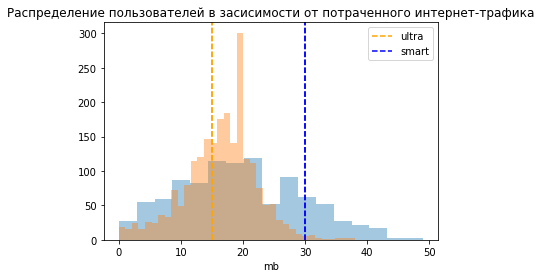

In [60]:
#строим график распределения интернет-трафика по двум тарифам:
for tariff in ['ultra', 'smart']:
    sns.distplot(group_all.query('tariff == @tariff')['mb'], kde=False, label=tariff)
    plt.title('Распределение пользователей в засисимости от потраченного интернет-трафика')
    plt.axvline(15, color = 'orange', linestyle = '--')
    plt.axvline(30, color = 'blue', linestyle = '--' )
_ = plt.legend(['ultra', 'smart'])

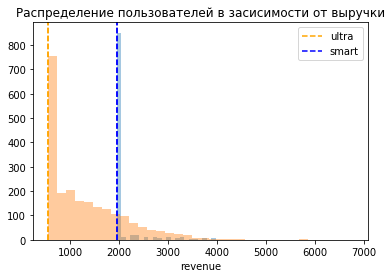

In [61]:
#строим график распределения выручки по двум тарифам:
for tariff in ['ultra', 'smart']:
    sns.distplot(group_all.query('tariff == @tariff')['revenue'], kde=False, label=tariff)
    plt.title('Распределение пользователей в засисимости от выручки')
    plt.axvline(550, color = 'orange', linestyle = '--')
    plt.axvline(1950, color = 'blue', linestyle = '--' )
_ = plt.legend(['ultra', 'smart'])

### Вывод

- Среднее использование минут по тарифу Smart - 417, лимит согласно тарифу составляет 500 минут, пользователи тарифа Smart укладываются в лимит.
- Среднее использование минут по тарифу Ultra - 526 в 6 раз меньше лимита, лимит согласно тарифу составляет 3000 минут, пользователи тарифа Ultra укладываются в лимит с большим запасом.
- Среднее использование смс-сообщениий по тарифу Smart - 33, лимит согласно тарифу составляет 50 смс, пользователи тарифа Smart укладываются в лимит.
- Среднее использование смс-сообщениий по тарифу Ultra - 49, лимит согласно тарифу составляет 1000 смс, пользователи тарифа Ultra укладываются в лимит с огромным запасом.
- Среднее использование интернет-трафика по тарифу Smart - 16,3Гб соответственно, лимит согласно тарифу составляет 15Гб, что говорит о перерасходе лимита на 1Гб. Пользователи тарифа Smart не укладываются в лимит.
- Среднее использование интернет-трафика по тарифу Ultra - 19,5Гб соответственно, лимит согласно тарифу составляет 30Гб. Пользователи тарифв Ultra укладываются в лимит с небольшим запасом.

 По гистограммам наглядно видно, что дисперсия по тарифу "Smart" меньше, чем у пользователей с тарифом "Ultra" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. 
 Другими словами, поведение пользователей тарифа "Ultra" более разнообразное с точки зрения потребления услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

<a id="4"></a>
## Шаг 4. Проверьте гипотезы

#### 1 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается
Нулевая гипотеза H₀:

"Средняя выручка пользователей тарифов "Ультра" и "Смарт" ***НЕ различается***"

Исходя из H₀ формулируется альтернативная гипотеза H₁:

"Средняя выручка пользователей тарифов "Ультра" и "Смарт" ***различается***"

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [62]:
#отделяю тариф Ультра и тариф Смарт по отдельности и делаю срез выручки:
ultra_revenue = group_all[group_all['tariff'] == 'ultra']['revenue'] 
#выберем всю выручку по всем абонентам по тарифу Смарт
smart_revenue = group_all[group_all['tariff'] == 'smart']['revenue'] 

In [63]:
#group_all.groupby('tariff')['revenue'].sum()

In [64]:
ultra_revenue.describe()

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64

In [65]:
smart_revenue.describe()

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64

In [82]:
import scipy
from scipy.stats import shapiro
shapiro(smart_revenue)

(0.8430357575416565, 2.022073684020711e-42)

In [83]:
shapiro(ultra_revenue)

(0.36749887466430664, 0.0)

In [68]:
[np.var(x, ddof=1) for x in [ultra_revenue, smart_revenue]]

[143491.24055961374, 673931.3213632443]

Так как дисперсия по тарифу Ультра намного больше дисперсии тарифа Смарт в параметр equal_var (от англ. equal variance, «равная дисперсия») нужно указать как False

In [69]:
alpha = 0.05 #критический уровень статистической значимости (если p-value окажется меньше него - отвергнем гипотезу)

results = st.ttest_ind(ultra_revenue, smart_revenue, equal_var = False) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


In [70]:
group_all.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,1038.0
ultra,1950.0


### Вывод
Средняя выручка пользователей тарифов «Ультра» и «Смарт» дейтсвительно различаются - наша альтернативная гипотеза подтвердилась. 

#### 2 - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Нулевая гипотеза H₀:

"Cредняя выручка пользователей из Москвы ***НЕ отличается*** от выручки пользователей из других регионов"

Исходя из H₀ формулируется альтернативная гипотеза H₁:

"Cредняя выручка пользователей из Москвы ***отличается*** от выручки пользователей из других регионов"

Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [71]:
#выберем всю выручку по всем абонентам по региону Москва
moscow_revenue = group_all[group_all['city'] == 'Москва']['revenue']
#выберем всю выручку по всем абонентам по всем остальным регионам
region_revenue = group_all[group_all['city'] != 'Москва']['revenue'] 

In [72]:
moscow_revenue.describe()

count     611.000000
mean     1550.805237
std       752.451347
min       550.000000
25%       798.000000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue, dtype: float64

In [73]:
region_revenue.describe()

count    2603.000000
mean     1528.316942
std       810.411374
min       550.000000
25%       750.000000
50%      1587.000000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

In [74]:
import scipy
scipy.stats.levene(moscow_revenue, region_revenue, center='median')

LeveneResult(statistic=6.758311885867126, pvalue=0.009373921759468934)

In [75]:
[np.var(x, ddof=1) for x in [moscow_revenue, region_revenue]]

[566183.0292184273, 656766.5955122438]

In [76]:
alpha = 0.05 #критический уровень статистической значимости (если p-value окажется меньше него - отвергнем гипотезу)

results = st.ttest_ind(moscow_revenue, region_revenue, equal_var = False) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


In [77]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
group_all['region'] = group_all['city'].apply(det_region)
group_all.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1587.0
Москва,1750.0


### Вывод
Гипотеза не подтвердилась и средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

<a id="5"></a>
## Шаг 5. Напишите общий вывод

Мы открыли все необходимые файлы, исследовали их, обнаружили пропуски и неверные типы данных.
Подготовили данные и провели статистический анализ.
Какой вывод общий сделан:
По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 960 рублей соответственно.

Особенности использования тарифов заключаются в следующем:
    - 70 % это пользователи тарифа "Смарт", 30% -"Ультра".
    - Средняя выручка от пользователя тарифа "Ультра" на ~ 45% выше тарифа "Смарт".
    - Большинству пользователей тарифа "Смарт" не хватает бесплатного кол-ва минут и трафика.
    - Пользователи тарифа "Ультра" пользуются минутами экономно и вписываются в свой лимит и даже остается большой запас по всем услугам.